C:\Users\herie\AppData\Local\Temp\ipykernel_6180\3582697135.py:308: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Loaded ^GSPC from 2010-01-04 to 2025-11-25 (N=4000, log=True).
Train length = 2400, val = 800, test = 800.

=== Building spectral solver for d=1 ===

=== Building spectral solver for d=2 ===

=== Building spectral solver for d=3 ===

=== Building spectral solver for d=4 ===

=== Minimizing validation MSE in s for d=1 (golden-section, spectral) ===

=== Scanning all local minima in s for d=1 ===

[d=1] found 2 local minima on [0.001,0.999]:
  s≈0.809595, J(s)≈1.261403e-02
  s≈0.999000, J(s)≈1.157925e-02


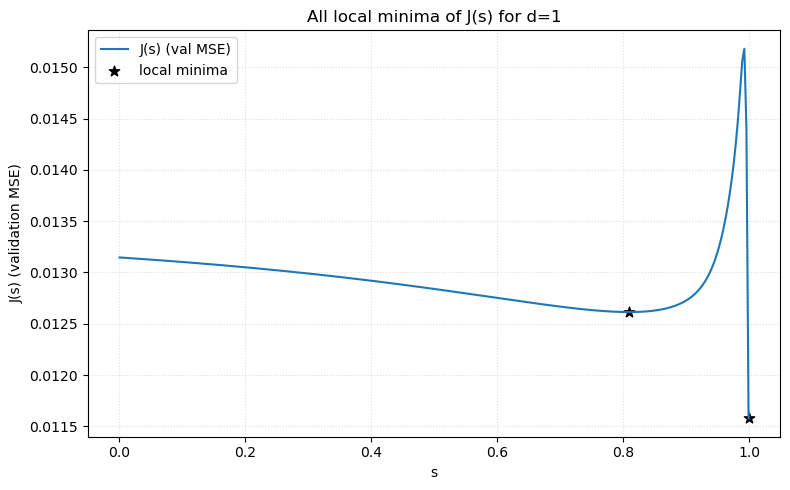


=== Minimizing validation MSE in s for d=2 (golden-section, spectral) ===

=== Scanning all local minima in s for d=2 ===

[d=2] found 3 local minima on [0.001,0.999]:
  s≈0.882066, J(s)≈8.493136e-03
  s≈0.985516, J(s)≈2.210094e-02
  s≈0.998917, J(s)≈2.006617e-02


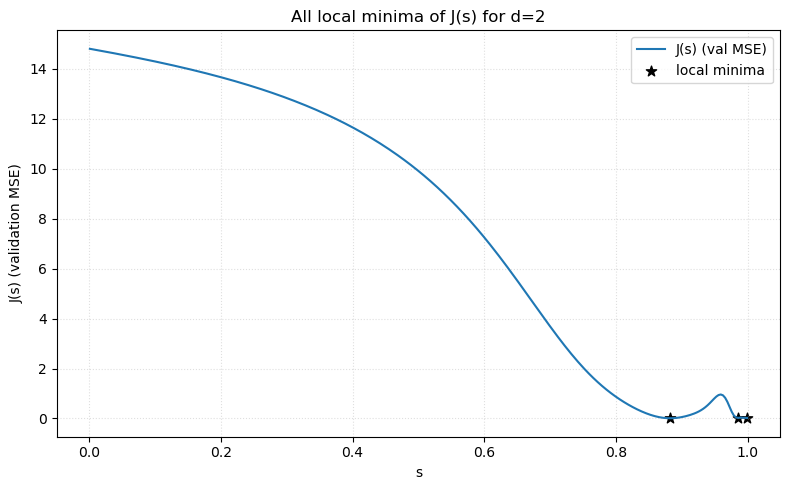


=== Minimizing validation MSE in s for d=3 (golden-section, spectral) ===

=== Scanning all local minima in s for d=3 ===

[d=3] found 5 local minima on [0.001,0.999]:
  s≈0.001000, J(s)≈2.135399e+05
  s≈0.920090, J(s)≈1.727146e+02
  s≈0.960556, J(s)≈3.489835e-01
  s≈0.985864, J(s)≈1.180702e-02
  s≈0.997193, J(s)≈1.108569e-01


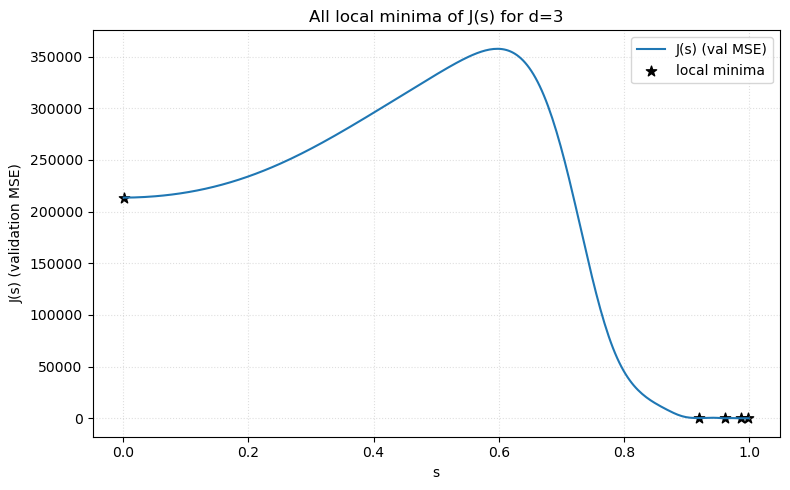


=== Minimizing validation MSE in s for d=4 (golden-section, spectral) ===

=== Scanning all local minima in s for d=4 ===


C:\Users\herie\AppData\Local\Temp\ipykernel_6180\3582697135.py:114: RuntimeWarning: divide by zero encountered in divide
  trAinv = np.sum(1.0 / denom)
C:\Users\herie\AppData\Local\Temp\ipykernel_6180\3582697135.py:175: RuntimeWarning: divide by zero encountered in divide
  z = y / denom                               # elementwise
C:\Users\herie\AppData\Local\Temp\ipykernel_6180\3582697135.py:176: RuntimeWarning: invalid value encountered in matmul
  t_hat = Q @ z                               # back to original basis
C:\Users\herie\AppData\Local\Temp\ipykernel_6180\3582697135.py:178: RuntimeWarning: invalid value encountered in matmul
  m_new = float(np.mean(K @ t_hat))
C:\Users\herie\AppData\Local\Temp\ipykernel_6180\3582697135.py:185: RuntimeWarning: divide by zero encountered in divide
  alpha = 1.0 / (1.0 + lam * eigvals)
C:\Users\herie\AppData\Local\Temp\ipykernel_6180\3582697135.py:187: RuntimeWarning: invalid value encountered in matmul
  diag_Ainv = (Q ** 2) @ alpha
C:\Users\h


[d=4] found 5 local minima on [0.001,0.999]:
  s≈0.001000, J(s)≈3.157143e+06
  s≈0.479330, J(s)≈2.602412e+04
  s≈0.929808, J(s)≈1.331620e+05
  s≈0.970090, J(s)≈3.315016e+00
  s≈0.987087, J(s)≈2.936238e+03


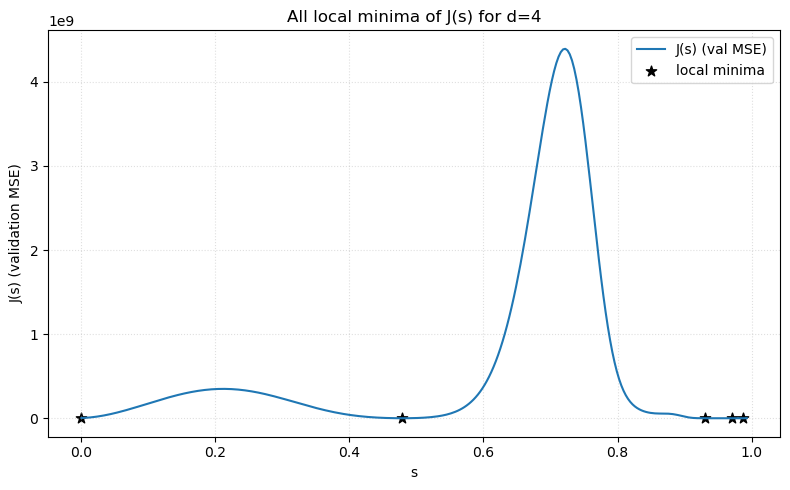

KeyError: 1

In [2]:
# -*- coding: utf-8 -*-
"""
Guerrero (2007) penalized trend on S&P 500 with spectral solver and
golden-section search in smoothness index s ∈ (0,1).

Pipeline:
  1) Load ^GSPC daily log-prices (via yfinance, or CSV).
  2) Split into train / validation / test.
  3) For each differencing order d in d_list:
       - Optimize validation MSE over s by golden-section.
       - Plot J(s) with all c_k, d_k, endpoints and chosen best.
  4) For each d, plot strict train/val/test fit with best s(d).
"""

from typing import Callable, Tuple, Dict, Any, Optional
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import comb as _comb


# ============================================================
#  Difference matrix
# ============================================================

def difference_matrix(N: int, d: int) -> np.ndarray:
    """
    Construct K: (N-d) x N implementing the d-th forward difference:

        (K τ)_t = Δ^d τ_t,  t = d,...,N-1.

    For d = 0, return I_N (no differencing).
    """
    if d == 0:
        return np.eye(N)
    K = np.zeros((N - d, N), dtype=float)
    coeffs = np.array([(-1) ** (d - k) * _comb(d, k) for k in range(d + 1)], dtype=float)
    for r in range(N - d):
        K[r, r: r + d + 1] = coeffs
    return K


# ============================================================
#  Spectral Guerrero solver: B = K'K = Q Λ Q'
# ============================================================

class GuerreroSpectralSolver:
    """
    Spectral implementation of Guerrero (2007) penalized trend
    for fixed (N, d).

    Precomputes:
      - K: (N-d) x N difference matrix
      - B = K'K: N x N PSD matrix
      - B = Q Λ Q': eigen-decomposition
      - K1 = K' 1 (N-d vector)

    Then for each λ:
      - solves (I + λ B) t = b(λ,m) via Q, Λ in O(N^2).
    """

    def __init__(self, N: int, d: int):
        self.N = int(N)
        self.d = int(d)
        self.K = difference_matrix(N, d)
        self.KT = self.K.T
        # B = K'K
        self.B = self.KT @ self.K                         # N x N, PSD
        # B = Q Λ Q'
        eigvals, Q = np.linalg.eigh(self.B)
        self.eigvals = eigvals                            # (N,)
        self.Q = Q                                        # N x N
        # K1 = K' * 1
        self.K1 = self.KT @ np.ones(N - d, dtype=float)   # (N,)
        # S_max = 1 - d/N (Guerrero normalization)
        self.S_max = 1.0 - d / N

    # ---------- smoothness map: s → λ via trace(A^-1) ----------

    def lambda_from_s(
        self,
        s_unit: float,
        tol: float = 1e-11,
        maxit: int = 80,
    ) -> float:
        """
        Map smoothness index s_unit ∈ [0,1) → λ solving:

            S_raw(λ) = 1 - (1/N) tr[(I + λ K'K)^(-1)],

        with
            tr[(I + λ K'K)^(-1)] = sum_{i=1}^N 1 / (1 + λ λ_i),

        where λ_i are eigenvalues of B = K'K.

        Then s_unit = S_raw(λ) / S_max, with S_max = 1 - d/N.
        """
        s_unit = float(s_unit)
        if s_unit <= 0.0:
            return 0.0
        if s_unit >= 1.0:
            s_unit = 0.999999

        if self.d == 0:
            # closed form when there's no difference penalty
            return s_unit / (1.0 - s_unit)

        target = s_unit * self.S_max
        eigvals = self.eigvals
        N = self.N

        def S_raw(lmb: float) -> float:
            denom = 1.0 + lmb * eigvals
            trAinv = np.sum(1.0 / denom)
            return 1.0 - trAinv / N

        lo, hi = 0.0, 1.0
        # enlarge hi until S_raw(hi) ≥ target
        while S_raw(hi) < target and hi < 1e16:
            hi *= 10.0

        for _ in range(maxit):
            mid = 0.5 * (lo + hi)
            Smid = S_raw(mid)
            if abs(Smid - target) < tol:
                return mid
            if Smid < target:
                lo = mid
            else:
                hi = mid
        return 0.5 * (lo + hi)

    # ---------- solve for a given λ using Q, Λ ----------

    def fit_for_lambda(
        self,
        Z: np.ndarray,
        lam: float,
        m_tol: float = 1e-10,
        max_m_iter: int = 120,
    ):
        """
        Given λ, compute Guerrero trend fit on a series Z of length N:

            t_hat = (I + λ K'K)^(-1) (Z + λ m K'1),

        with fixed-point iteration in m = mean(K t_hat).

        Uses spectral decomposition B = Q Λ Q', so complexity per λ is O(N^2).

        Returns:
            t_hat       : trend fit (N,)
            m_hat       : scalar drift
            sigma2_hat  : variance estimate
            diag_Ainv   : diagonal of (I + λ K'K)^(-1)
            s_unit_real : realized smoothness index S_raw / S_max
        """
        Z = np.asarray(Z, dtype=float).ravel()
        if Z.size != self.N:
            raise ValueError(f"Z length {Z.size} != N {self.N} in solver.")

        N = self.N
        d = self.d
        K = self.K
        Q = self.Q
        eigvals = self.eigvals

        # initial m from raw differences
        m = float(np.mean(K @ Z))

        for _ in range(max_m_iter):
            b = Z + lam * m * self.K1                   # RHS
            y = Q.T @ b                                 # transform to eigenbasis
            denom = 1.0 + lam * eigvals
            z = y / denom                               # elementwise
            t_hat = Q @ z                               # back to original basis

            m_new = float(np.mean(K @ t_hat))
            if abs(m_new - m) < m_tol:
                m = m_new
                break
            m = m_new

        # eigenvalues of A^-1 are α_i = 1 / (1 + λ λ_i)
        alpha = 1.0 / (1.0 + lam * eigvals)
        # diag(A^-1)_j = Σ_i α_i Q_{ji}^2
        diag_Ainv = (Q ** 2) @ alpha

        resid = Z - t_hat
        pen = (K @ t_hat) - m
        dof = max(1, N - d - 1)
        sigma2_hat = float((resid.T @ resid + lam * (pen.T @ pen)) / dof)

        trAinv = np.sum(alpha)
        S_raw = 1.0 - trAinv / N
        s_unit_real = S_raw / self.S_max if self.S_max > 0 else 0.0

        return t_hat, m, sigma2_hat, diag_Ainv, s_unit_real

    # ---------- convenience: fit from s ----------

    def fit_for_s(
        self,
        Z: np.ndarray,
        s_unit: float,
        m_tol: float = 1e-10,
        max_m_iter: int = 120,
    ):
        """
        Given s ∈ (0,1), map to λ and fit Guerrero trend.

        Returns:
            t_hat       : trend fit (N,)
            m_hat       : scalar drift
            lam         : λ
            sigma2_hat  : variance estimate
            diag_Ainv   : diag(A^-1)
            s_unit_real : realized smoothness index
        """
        lam = self.lambda_from_s(s_unit)
        t_hat, m_hat, sigma2_hat, diag_Ainv, s_unit_real = self.fit_for_lambda(
            Z, lam, m_tol=m_tol, max_m_iter=max_m_iter
        )
        return t_hat, m_hat, lam, sigma2_hat, diag_Ainv, s_unit_real


# ============================================================
#  Forecast of trend (any d)
# ============================================================

def forecast_trend(t_hat: np.ndarray, d: int, m_hat: float, h: int) -> np.ndarray:
    """
    h-step-ahead forecast of the trend/mean for arbitrary d ≥ 0.

    d = 0 : constant trend
    d = 1 : linear trend
    d ≥ 2 : higher-order polynomial trend implied by Δ^d t_t = m_hat.
    """
    t_hat = np.asarray(t_hat, dtype=float).ravel()
    if h <= 0:
        return np.array([], dtype=float)

    if d == 0:
        return np.full(h, m_hat, dtype=float)
    if d < 0:
        raise ValueError("d must be ≥ 0")

    N = t_hat.size
    d_eff = min(d, N)

    last = t_hat[-d_eff:].copy()  # last d_eff values of trend

    # coefficients in:
    #   t_t = m_hat - Σ_{k=0}^{d_eff-1} (-1)^{d_eff-k} C(d_eff,k) t_{t-d_eff+k}
    coeffs = np.array(
        [(-1) ** (d_eff - k) * _comb(d_eff, k) for k in range(d_eff)],
        dtype=float,
    )

    out = np.empty(h, dtype=float)
    for i in range(h):
        sum_prev = float(coeffs @ last)
        next_val = m_hat - sum_prev
        out[i] = next_val
        # shift window
        last[:-1] = last[1:]
        last[-1] = next_val

    return out


# ============================================================
#  Data: S&P 500 daily
# ============================================================

def load_sp500_series(
    ticker: str = "^GSPC",
    start: str = "2010-01-01",
    end: Optional[str] = None,
    use_log: bool = True,
    csv_path: Optional[str] = None,
) -> Tuple[np.ndarray, np.ndarray, Dict[str, Any]]:
    """
    Load daily S&P 500 (or any Yahoo-compatible ticker).

    If csv_path is not None:
      - Expect columns 'Date' and 'Adj Close' or 'Close'.

    Else:
      - Use yfinance to download.

    Returns:
      t    : indices 0..N-1
      Z    : log-prices (or prices) of length N
      meta : dict with ticker, start, end, use_log
    """
    if csv_path is not None:
        df = pd.read_csv(csv_path, parse_dates=["Date"])
        df = df.sort_values("Date")
    else:
        try:
            import yfinance as yf
        except ImportError as e:
            raise ImportError(
                "yfinance is required; install with `pip install yfinance`, "
                "or pass csv_path with local data."
            ) from e
        df = yf.download(ticker, start=start, end=end)
        if df.empty:
            raise RuntimeError("Failed to download data from Yahoo Finance.")

    for col in ["Adj Close", "AdjClose", "Close", "close"]:
        if col in df.columns:
            px = df[col].dropna()
            break
    else:
        raise ValueError("No price column found ('Adj Close' or 'Close').")

    Z = px.to_numpy(dtype=float).ravel()
    if use_log:
        Z = np.log(Z)

    t = np.arange(Z.size, dtype=float)
    meta = dict(
        ticker=ticker,
        start=str(px.index[0].date()),
        end=str(px.index[-1].date()),
        use_log=use_log,
    )
    return t, Z, meta


def train_val_test_split(
    Z: np.ndarray,
    frac_train: float = 0.6,
    frac_val: float = 0.2,
    min_train: int = 50,
    min_val: int = 50,
):
    """
    3-way split of 1D series Z into train / validation / test.
    Fractions are approximate; min_train / min_val are enforced.
    """
    Z = np.asarray(Z, dtype=float).ravel()
    N = Z.size

    N_train = max(min_train, int(frac_train * N))
    N_val = max(min_val, int(frac_val * N))

    if N_train + N_val >= N:
        N_val = max(1, N - 1 - N_train)
        if N_val < min_val:
            N_train = max(min_train, N - 1 - N_val)

    N_test = N - N_train - N_val
    if N_test < 1:
        N_test = 1
        N_val = 0
        N_train = N - N_test

    Z_train = Z[:N_train]
    Z_val = Z[N_train:N_train + N_val]
    Z_test = Z[N_train + N_val:]

    return Z_train, Z_val, Z_test, N_train, N_val, N_test


# ============================================================
#  Golden-section minimization in s (with endpoints + plot)
# ============================================================

def golden_local(
    J: Callable[[float], float],
    a: float,
    b: float,
    n_iter: int = 20,
) -> Tuple[float, float]:
    """
    Golden-section search restricted to [a,b], assuming J is
    unimodal on that interval. Returns (s_star, J(s_star)).
    """
    phi = (1.0 + np.sqrt(5.0)) / 2.0
    invphi = 1.0 / phi

    c = b - invphi * (b - a)
    d_s = a + invphi * (b - a)
    f_c = J(c)
    f_d = J(d_s)

    for _ in range(n_iter):
        if f_c < f_d:
            b = d_s
            d_s = c
            f_d = f_c
            c = b - invphi * (b - a)
            f_c = J(c)
        else:
            a = c
            c = d_s
            f_c = f_d
            d_s = a + invphi * (b - a)
            f_d = J(d_s)

    s_star = 0.5 * (a + b)
    J_star = J(s_star)
    return s_star, J_star


def find_all_local_minima_s(
    J: Callable[[float], float],
    d: int,
    s_min: float = 1e-3,
    s_max: float = 0.999,
    n_grid: int = 300,
    refine: bool = True,
    refine_iter: int = 20,
    verbose: bool = True,
    plot: bool = True,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Approximate all local minima of J(s) on [s_min, s_max].

    Steps:
      1) Evaluate J on a grid of n_grid points.
      2) Detect indices i where J[i] <= J[i-1], J[i] <= J[i+1].
      3) (Optional) Refine each candidate via golden-section on
         a small bracket around it.

    Returns:
      s_minima : array of s locations
      J_minima : array of J(s) at those locations
    """
    # 1) coarse grid
    s_grid = np.linspace(s_min, s_max, n_grid)
    J_grid = np.array([J(s) for s in s_grid])

    # 2) discrete local minima
    idx_candidates = []

    # interior points
    for i in range(1, n_grid - 1):
        if (J_grid[i] <= J_grid[i - 1]) and (J_grid[i] <= J_grid[i + 1]):
            idx_candidates.append(i)

    # optional: endpoints as minima
    if J_grid[0] <= J_grid[1]:
        idx_candidates.append(0)
    if J_grid[-1] <= J_grid[-2]:
        idx_candidates.append(n_grid - 1)

    # 3) refine each candidate
    s_list = []
    J_list = []

    for idx in idx_candidates:
        s0 = s_grid[idx]

        if refine:
            if 0 < idx < n_grid - 1:
                a = s_grid[idx - 1]
                b = s_grid[idx + 1]
            elif idx == 0:
                a = s_grid[0]
                b = s_grid[1]
            else:  # idx == n_grid - 1
                a = s_grid[-2]
                b = s_grid[-1]

            s_star, J_star = golden_local(J, a, b, n_iter=refine_iter)
        else:
            s_star = s0
            J_star = J_grid[idx]

        s_list.append(s_star)
        J_list.append(J_star)

    # convert to arrays and sort by s
    s_minima = np.array(s_list, dtype=float)
    J_minima = np.array(J_list, dtype=float)
    order = np.argsort(s_minima)
    s_minima = s_minima[order]
    J_minima = J_minima[order]

    if verbose:
        print(f"\n[d={d}] found {len(s_minima)} local minima on [{s_min:.3g},{s_max:.3g}]:")
        for s_star, J_star in zip(s_minima, J_minima):
            print(f"  s≈{s_star:.6f}, J(s)≈{J_star:.6e}")

    if plot:
        plt.figure(figsize=(8, 5))
        ax = plt.gca()
        ax.plot(s_grid, J_grid, label="J(s) (val MSE)", linewidth=1.5)
        ax.scatter(s_minima, J_minima, s=60, marker="*", color="k",
                   label="local minima")
        ax.set_title(f"All local minima of J(s) for d={d}")
        ax.set_xlabel("s")
        ax.set_ylabel("J(s) (validation MSE)")
        ax.legend()
        ax.grid(True, linestyle=":", alpha=0.4)
        plt.tight_layout()
        plt.show()

    return s_minima, J_minima


def minimize_s_golden(
    J: Callable[[float], float],
    d: int,
    s_min: float = 1e-3,
    s_max: float = 0.999,
    n_iter: int = 25,
    verbose: bool = True,
    plot_progress: bool = False,
    n_grid: int = 120,
) -> Tuple[float, float]:
    """
    Minimize J(s) over s in [s_min, s_max] using golden-section search.

    - Evaluate endpoints s_min, s_max once.
    - Do golden-section on interior bracket (a,b).
    - Compare interior optimum vs endpoints, return the best.

    If plot_progress=True, also plot:
      - J(s) on a grid,
      - all (c_k, J(c_k)) and (d_k, J(d_k)),
      - endpoints,
      - chosen best.
    """
    # original endpoints
    s_lo0 = float(s_min)
    s_hi0 = float(s_max)

    J_lo0 = J(s_lo0)
    J_hi0 = J(s_hi0)

    if verbose:
        print(f"[d={d}] endpoints: J(a={s_lo0:.4g})={J_lo0:.6e}, "
              f"J(b={s_hi0:.4g})={J_hi0:.6e}")

    # golden-section on (a,b)
    phi = (1.0 + np.sqrt(5.0)) / 2.0
    invphi = 1.0 / phi

    a = s_lo0
    b = s_hi0

    c = b - invphi * (b - a)
    d_s = a + invphi * (b - a)

    f_c = J(c)
    f_d = J(d_s)

    history: list[tuple[float, float, float, float]] = []
    history.append((c, f_c, d_s, f_d))

    if verbose:
        print(f"[d={d}] init: a={a:.4f}, c={c:.4f}, d={d_s:.4f}, b={b:.4f}")
        print(f"[d={d}]      J(c)={f_c:.6e}, J(d)={f_d:.6e}")

    for k in range(n_iter):
        if f_c < f_d:
            # minimum (under unimodality) in [a, d_s]
            b = d_s
            d_s = c
            f_d = f_c
            c = b - invphi * (b - a)
            f_c = J(c)
        else:
            # minimum in [c, b]
            a = c
            c = d_s
            f_c = f_d
            d_s = a + invphi * (b - a)
            f_d = J(d_s)

        history.append((c, f_c, d_s, f_d))

        if verbose:
            print(
                f"[d={d}] iter={k:02d} | "
                f"a={a:.4f}, c={c:.4f}, d={d_s:.4f}, b={b:.4f} | "
                f"J(c)={f_c:.6e}, J(d)={f_d:.6e}"
            )

    # interior optimum from final bracket
    s_int = 0.5 * (a + b)
    J_int = J(s_int)

    # pick best among endpoints + interior
    cand_s = [s_lo0, s_hi0, s_int]
    cand_J = [J_lo0, J_hi0, J_int]
    idx_best = int(np.argmin(cand_J))
    s_best = cand_s[idx_best]
    J_best = cand_J[idx_best]
    where = ["s_min", "s_max", "interior"][idx_best]

    if verbose:
        print(
            f"[d={d}] final: s_best≈{s_best:.6f} (from {where}), "
            f"val_MSE≈{J_best:.6e}"
        )

    # optional visualization
    if plot_progress:
        s_grid = np.linspace(s_lo0, s_hi0, n_grid)
        J_grid = np.array([J(s) for s in s_grid])

        plt.figure(figsize=(8, 5))
        ax = plt.gca()

        # full curve
        ax.plot(s_grid, J_grid, label="J(s) (val MSE)", linewidth=1.5)

        # history of c_k, d_k
        c_list  = [h[0] for h in history]
        fc_list = [h[1] for h in history]
        d_list  = [h[2] for h in history]
        fd_list = [h[3] for h in history]

        ax.scatter(c_list, fc_list, s=25, marker="o", label="c_k, J(c_k)")
        ax.scatter(d_list, fd_list, s=25, marker="x", label="d_k, J(d_k)")

        # endpoints
        ax.scatter([s_lo0], [J_lo0], s=50, marker="s", label="s_min, J(s_min)")
        ax.scatter([s_hi0], [J_hi0], s=50, marker="D", label="s_max, J(s_max)")

        # chosen best
        ax.scatter([s_best], [J_best], s=80, marker="*", color="k", label="best")

        ax.set_title(f"Golden-section + endpoints for d={d}")
        ax.set_xlabel("s")
        ax.set_ylabel("J(s) (validation MSE)")
        ax.legend()
        ax.grid(True, linestyle=":", alpha=0.4)
        plt.tight_layout()
        plt.show()

    return s_best, J_best


# ============================================================
#  Visualization per d with strict train/val/test protocol
# ============================================================

def plot_d_train_val_test_strict(
    Z_all: np.ndarray,
    N_train: int,
    N_val: int,
    d: int,
    s_unit: float,
    solver: GuerreroSpectralSolver,
    meta: Dict[str, Any],
):
    """
    Strict split visualization for one d:
      - Fit Guerrero trend with (d, s_unit) on TRAIN via solver.
      - Forecast over VAL and TEST.
      - Plot Z_t and trend/forecasts.
    """
    Z_all = np.asarray(Z_all, dtype=float).ravel()
    N_all = Z_all.size

    Z_train = Z_all[:N_train]
    Z_val = Z_all[N_train:N_train + N_val]
    Z_test = Z_all[N_train + N_val:]
    N_val = Z_val.size
    N_test = Z_test.size

    t_hat, m_hat, lam, sigma2_hat, diag_Ainv, s_real = solver.fit_for_s(Z_train, s_unit)
    t_hat = np.asarray(t_hat, dtype=float).ravel()

    h_total = N_val + N_test
    t_fore_all = forecast_trend(t_hat, d=d, m_hat=m_hat, h=h_total)
    t_fore_val = t_fore_all[:N_val]
    t_fore_test = t_fore_all[N_val:]

    rmse_train = float(np.sqrt(np.mean((t_hat - Z_train) ** 2)))
    rmse_val = float(np.sqrt(np.mean((t_fore_val - Z_val) ** 2))) if N_val > 0 else np.nan
    rmse_test = float(np.sqrt(np.mean((t_fore_test - Z_test) ** 2))) if N_test > 0 else np.nan

    idx_all = np.arange(N_all)
    idx_train = idx_all[:N_train]
    idx_val = idx_all[N_train:N_train + N_val]
    idx_test = idx_all[N_train + N_val:]

    plt.figure(figsize=(11, 5))
    ax = plt.gca()

    ax.plot(idx_train, Z_train, label="Z_t (train)", linewidth=1.0)
    if N_val > 0:
        ax.plot(idx_val, Z_val, label="Z_t (val)", linewidth=1.0)
    if N_test > 0:
        ax.plot(idx_test, Z_test, label="Z_t (test)", linewidth=1.0)

    ax.plot(idx_train, t_hat, label="trend (fit on train)", linewidth=2.0)

    if N_val > 0:
        ax.plot(idx_val, t_fore_val, "--", label="trend forecast (val)", linewidth=2.0)
    if N_test > 0:
        ax.plot(idx_test, t_fore_test, "--", label="trend forecast (test)", linewidth=2.0)

    ax.axvline(N_train - 0.5, color="k", linestyle="--", linewidth=1)
    ax.text(N_train - 0.5, ax.get_ylim()[1], "train | val",
            ha="right", va="top", fontsize=8)
    if N_val > 0:
        ax.axvline(N_train + N_val - 0.5, color="k", linestyle=":", linewidth=1)
        ax.text(N_train + N_val - 0.5, ax.get_ylim()[1], "val | test",
                ha="right", va="top", fontsize=8)

    ax.set_title(
        f"{meta['ticker']} – d={d}, s≈{s_unit:.3f}, λ≈{lam:.3g}, m̂≈{m_hat:.4f}\n"
        f"RMSE(train)={rmse_train:.4f}, RMSE(val)={rmse_val:.4f}, RMSE(test)={rmse_test:.4f}"
    )
    ax.set_xlabel("t (days)")
    ax.set_ylabel("log-price")
    ax.legend(loc="best", fontsize=8)
    ax.grid(True, linestyle=":", alpha=0.4)
    plt.tight_layout()
    plt.show()


# ============================================================
#  Main
# ============================================================

def main():
    # 1. Load S&P 500
    t_all, Z_all, meta = load_sp500_series(
        ticker="^GSPC",
        start="2010-01-01",
        end=None,
        use_log=True,
        csv_path=None,  # or path to CSV with Date / Adj Close
    )

    print(
        f"Loaded {meta['ticker']} from {meta['start']} to {meta['end']} "
        f"(N={Z_all.size}, log={meta['use_log']})."
    )

    # 2. Train / validation / test split
    Z_train, Z_val, Z_test, N_train, N_val, N_test = train_val_test_split(
        Z_all,
        frac_train=0.6,
        frac_val=0.2,
        min_train=80,
        min_val=60,
    )
    print(f"Train length = {N_train}, val = {N_val}, test = {N_test}.")

    # 3. Build spectral solvers per d (for train length)
    d_list = [1, 2, 3, 4]   # extend if numerically stable, e.g. [1,2,3,4]
    solvers: Dict[int, GuerreroSpectralSolver] = {}
    for d in d_list:
        print(f"\n=== Building spectral solver for d={d} ===")
        solvers[d] = GuerreroSpectralSolver(N_train, d)

    # 4. For each d, define J_d(s) and minimize via golden-section
    best_by_d: Dict[int, Dict[str, Any]] = {}
    for d in d_list:
        solver = solvers[d]

        def J_d(s: float, _solver=solver, _d=d) -> float:
            if N_val == 0:
                return np.nan
            try:
                t_hat, m_hat, lam, sigma2_hat, diag_Ainv, s_real = _solver.fit_for_s(Z_train, s)
            except Exception:
                return np.inf
            t_fore = forecast_trend(t_hat, d=_d, m_hat=m_hat, h=N_val)
            return float(np.mean((t_fore - Z_val) ** 2))

        print(f"\n=== Minimizing validation MSE in s for d={d} "
              f"(golden-section, spectral) ===")
        # s_star, loss_star = minimize_s_golden(
        #     J_d,
        #     d=d,
        #     s_min=1e-3,
        #     s_max=0.999,
        #     n_iter=25,
        #     verbose=True,
        #     plot_progress=True,
        #     n_grid=120,
        # )
        # best_by_d[d] = dict(s=s_star, loss=loss_star)
        # print(f"[summary] d={d}: s*≈{s_star:.6f}, val_MSE≈{loss_star:.6e}")

            # After:
    # s_star, loss_star = minimize_s_golden(...)

        # Optionally scan for all local minima:
        print(f"\n=== Scanning all local minima in s for d={d} ===")
        s_all, J_all = find_all_local_minima_s(
            J_d,
            d=d,
            s_min=1e-3,
            s_max=0.999,
            n_grid=300,      # increase if you want more resolution
            refine=True,
            refine_iter=20,
            verbose=True,
            plot=True,
        )


    # 5. Visualizations per d with strict train/val/test
    for d in d_list:
        s_star = best_by_d[d]["s"]
        loss = best_by_d[d]["loss"]
        if not np.isfinite(loss) or not np.isfinite(s_star):
            print(f"\n--- Skipping d={d}: non-finite best loss or s ---")
            continue

        print(f"\n--- Plotting train/val/test for d={d}, s≈{s_star:.4f} ---")
        solver = solvers[d]
        plot_d_train_val_test_strict(
            Z_all=Z_all,
            N_train=N_train,
            N_val=N_val,
            d=d,
            s_unit=s_star,
            solver=solver,
            meta=meta,
        )


if __name__ == "__main__":
    main()
